In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Load your DataFrame here
df = pd.read_csv('60mins_data.csv')  # Assuming data is loaded into final_df

In [2]:
df.set_index('Datetime', inplace = True)
df.index = pd.to_datetime(df.index)

def rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))
df['RSI'] = rsi(df['Close'])

In [3]:
# Split data into training and testing sets
train_df = df[df['Chronological']==False]
test_df = df[df['Chronological']==True]

# Scale the Close prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df[['Close']])
scaled_test_data = scaler.transform(test_df[['Close']])

# Function to create dataset for LSTM
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, verbose=1)



Epoch 1/10

186/186 [==============================] - 8s 23ms/step - loss: 0.0075 - val_loss: 8.8916e-04
Epoch 2/10
186/186 [==============================] - 4s 19ms/step - loss: 3.7313e-04 - val_loss: 0.0015
Epoch 3/10
186/186 [==============================] - 4s 19ms/step - loss: 3.5012e-04 - val_loss: 9.4713e-04
Epoch 4/10
186/186 [==============================] - 4s 19ms/step - loss: 3.1667e-04 - val_loss: 0.0020
Epoch 5/10
186/186 [==============================] - 4s 19ms/step - loss: 3.1057e-04 - val_loss: 0.0011
Epoch 6/10
186/186 [==============================] - 4s 19ms/step - loss: 2.6994e-04 - val_loss: 2.8326e-04
Epoch 7/10
186/186 [==============================] - 4s 19ms/step - loss: 2.5500e-04 - val_loss: 0.0011
Epoch 8/10
186/186 [==============================] - 4s 20ms/step - loss: 2.4670e-04 - val_loss: 5.8271e-04
Epoch 9/10
186/186 [==============================] - 4s 19ms/step - loss: 2.3168e-04 - val_loss: 4.3145e-04
Epoch 10/10
186/186 [===============

In [4]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform actuals
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
train_mse = mean_squared_error(y_train_inv, train_predict)
test_mse = mean_squared_error(y_test_inv, test_predict)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

train_mape = mean_absolute_percentage_error(y_train_inv, train_predict)
test_mape = mean_absolute_percentage_error(y_test_inv, test_predict)
print("Train MAPE:", train_mape)
print("Test MAPE:", test_mape)

57/57 [==============================] - 0s 6ms/step
Train MSE: 349.232271919916
Test MSE: 774.5856773402913
Train MAPE: 0.003196143744956488
Test MAPE: 0.004780963860374539


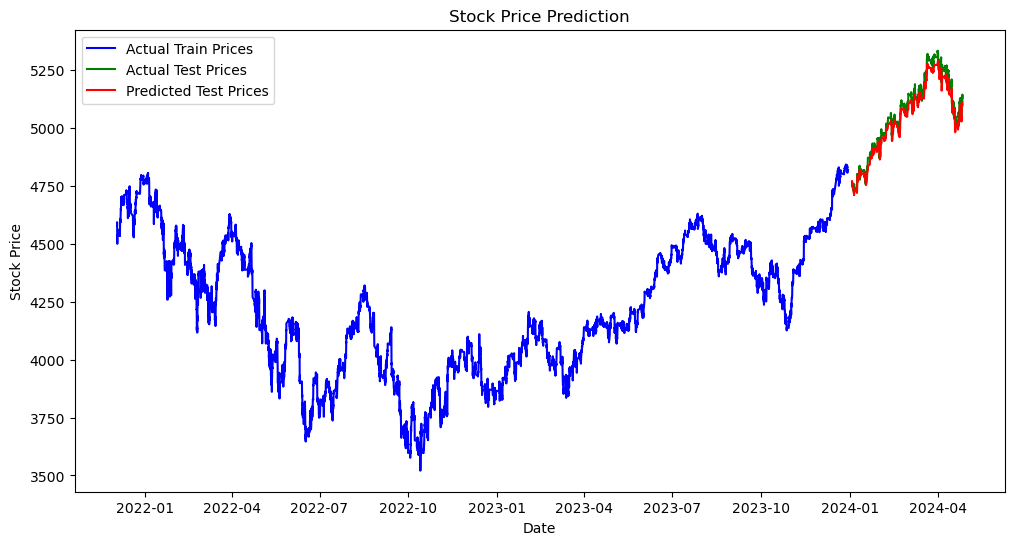

In [5]:
# Plotting
plt.figure(figsize=(12, 6))

# Correct the indices for train and test data to match the outputs
train_indices = train_df.index[time_step+1:len(train_predict)+time_step+1]
test_indices = test_df.index[time_step+1:len(test_predict)+time_step+1]

plt.plot(train_indices, y_train_inv, label='Actual Train Prices', color='blue')
plt.plot(test_indices, y_test_inv, label='Actual Test Prices', color='green')
plt.plot(test_indices, test_predict, label='Predicted Test Prices', color='red')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


C:\Users\saite\AppData\Local\Temp\ipykernel_24896\878598978.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Capital'].iloc[i] = capital
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\878598978.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Holdings'].iloc[i] = current_holdings
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\878598978.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

C:\Users\saite\AppData\Local\Temp\ipykernel_24896\878598978.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Holdings'].iloc[i] = current_holdings
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\878598978.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Capital'].iloc[i] = capital
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\878598978.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

Starting capital: $100,000.00
Ending portfolio value: $102,988.01
Profit / Loss: $2,988.01


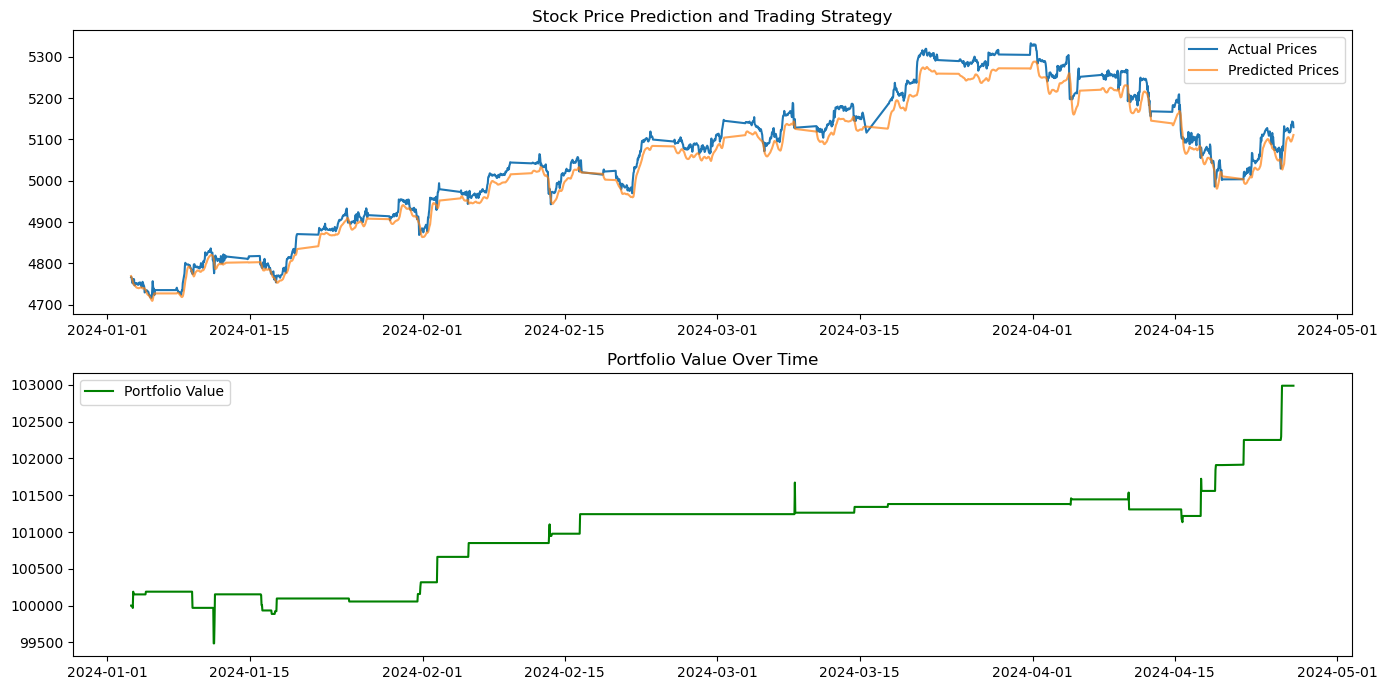

In [6]:
# Set initial capital and current holdings
initial_capital = 100000.0
current_holdings = 0.0
capital = initial_capital

# Create a DataFrame to store trades and capital over time
trading_record = pd.DataFrame(index=test_df.index[time_step+1:len(test_predict)+time_step+1])
trading_record['Actual'] = y_test_inv.ravel()
trading_record['Predicted'] = test_predict.ravel()
trading_record['Capital'] = initial_capital
trading_record['Holdings'] = 0.0

# Simulate trading
for i in range(1, len(trading_record)):
    if trading_record['Predicted'].iloc[i] > trading_record['Actual'].iloc[i-1]:
        # Buy signal: Invest all available capital
        if capital > 0:
            current_holdings = capital / trading_record['Actual'].iloc[i]
            capital = 0.0
    elif trading_record['Predicted'].iloc[i] < trading_record['Actual'].iloc[i-1]:
        # Sell signal: Sell all holdings
        if current_holdings > 0:
            capital = current_holdings * trading_record['Actual'].iloc[i]
            current_holdings = 0.0
    
    # Update capital and holdings records
    trading_record['Capital'].iloc[i] = capital
    trading_record['Holdings'].iloc[i] = current_holdings

# Calculate final value of portfolio (capital + value of holdings)
final_value = capital + current_holdings * trading_record['Actual'].iloc[-1]
print(f"Starting capital: ${initial_capital:,.2f}")
print(f"Ending portfolio value: ${final_value:,.2f}")
print(f"Profit / Loss: ${final_value - initial_capital:,.2f}")

# Plotting the backtest results
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(trading_record.index, trading_record['Actual'], label='Actual Prices')
plt.plot(trading_record.index, trading_record['Predicted'], label='Predicted Prices', alpha=0.7)
plt.title('Stock Price Prediction and Trading Strategy')
plt.legend()

plt.subplot(2, 1, 2)
portfolio_value = trading_record['Capital'] + trading_record['Holdings'] * trading_record['Actual']
plt.plot(trading_record.index, portfolio_value, label='Portfolio Value', color='green')
plt.title('Portfolio Value Over Time')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Capital'].iloc[i] = capital
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Holdings'].iloc[i] = current_holdings
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Capital'].iloc[i] = capital
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Holdings'].iloc[i] = current_holdings
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Capital'].iloc[i] = capital
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Holdings'].iloc[i] = current_holdings
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Capital'].iloc[i] = capital
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trading_record['Holdings'].iloc[i] = current_holdings
C:\Users\saite\AppData\Local\Temp\ipykernel_24896\855597237.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

Starting capital: $100,000.00
Ending portfolio value: $105,088.69
Profit / Loss: $5,088.69


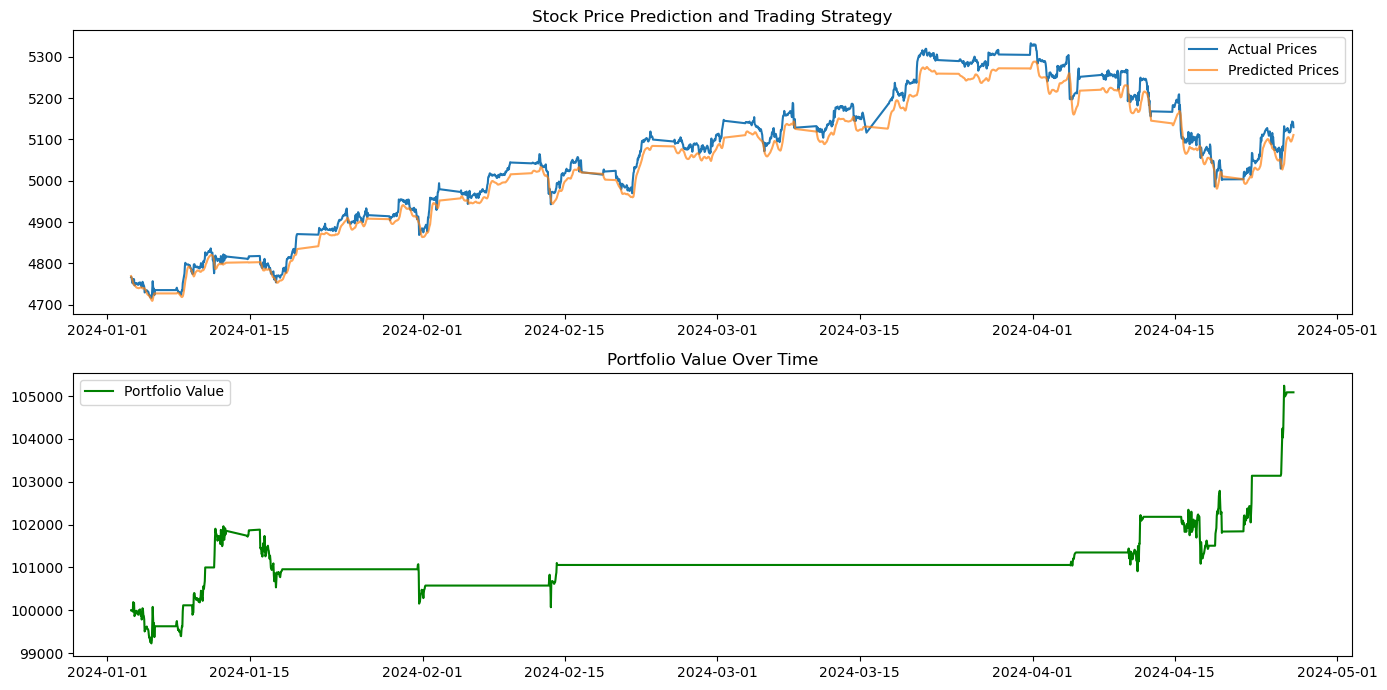

In [8]:
initial_capital = 100000.0
current_holdings = 0.0
capital = initial_capital

# Create a DataFrame to store trades and capital over time
trading_record = pd.DataFrame(index=test_df.index[time_step+1:len(test_predict)+time_step+1])
trading_record['Actual'] = y_test_inv.ravel()
trading_record['Predicted'] = test_predict.ravel()
trading_record['Capital'] = initial_capital
trading_record['Holdings'] = 0.0

# Simulate trading
for i in range(1, len(trading_record)):
    rsi_current = test_df['RSI'].iloc[i + time_step]
    if (trading_record['Predicted'].iloc[i] > trading_record['Actual'].iloc[i-1]) and rsi_current<30:
        # Buy signal: Invest all available capital
        if capital > 0:
            current_holdings = capital / trading_record['Actual'].iloc[i]
            capital = 0.0
    elif (trading_record['Predicted'].iloc[i] < trading_record['Actual'].iloc[i-1]) and rsi_current>70:
        # Sell signal: Sell all holdings
        if current_holdings > 0:
            capital = current_holdings * trading_record['Actual'].iloc[i]
            current_holdings = 0.0
    
    # Update capital and holdings records
    trading_record['Capital'].iloc[i] = capital
    trading_record['Holdings'].iloc[i] = current_holdings

# Calculate final value of portfolio (capital + value of holdings)
final_value = capital + current_holdings * trading_record['Actual'].iloc[-1]
print(f"Starting capital: ${initial_capital:,.2f}")
print(f"Ending portfolio value: ${final_value:,.2f}")
print(f"Profit / Loss: ${final_value - initial_capital:,.2f}")

# Plotting the backtest results
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(trading_record.index, trading_record['Actual'], label='Actual Prices')
plt.plot(trading_record.index, trading_record['Predicted'], label='Predicted Prices', alpha=0.7)
plt.title('Stock Price Prediction and Trading Strategy')
plt.legend()

plt.subplot(2, 1, 2)
portfolio_value = trading_record['Capital'] + trading_record['Holdings'] * trading_record['Actual']
plt.plot(trading_record.index, portfolio_value, label='Portfolio Value', color='green')
plt.title('Portfolio Value Over Time')
plt.legend()

plt.tight_layout()
plt.show()
